In [ ]:
!pip install nltk --user

# Import the libraries

In [ ]:
# import the dataset from sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import other required libs
import pandas as pd
import numpy as np

# string manipulation libs
import re
import string
import nltk
from nltk.corpus import stopwords

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns


categories = [
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'alt.atheism',
 'soc.religion.christian',
]
dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))


In [ ]:
#Convert dataset in to DataFrame Format
df = pd.DataFrame(dataset.data, columns=["corpus"])

In [ ]:
df.head()

In [20]:
df.shape

(3451, 2)

# Preprocess Text

In [ ]:
#Removing the Stopwords from text

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

stopwords.words("english")[:10] # <-- import the english stopwords

In [21]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    # print(text)
    return text

In [22]:
df['cleaned'] = df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [23]:
df.head()

,corpus,cleaned
0,"\nThey tried their best not to show it, believ...",tried best show believe surprised find sprint ...
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,stankiewicz doubt koufax one two jewish hofs h...
2,\n[deletia- and so on]\n\nI seem to have been ...,deletia seem rather unclear asking please show...
3,"Excuse the sheer newbieness of this post, but ...",excuse sheer newbieness post looking decent pa...
4,==============================================...,


# TF-IDF Vectorization

In [24]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned'])

In [26]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# K-Means Clustering

In [27]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [29]:
[c for c in clusters][:10]

[0, 0, 2, 1, 0, 0, 0, 1, 1, 1]

# PCA

In [36]:
X.shape

(3451, 7390)

In [30]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [31]:
print(x0)
print(x1)

[-0.00152024 -0.03644996 -0.06548033 ...  0.18883194  0.03557314
 -0.05786917]
[-0.00430002 -0.03914495  0.08785332 ...  0.05718469 -0.03828756
 -0.10444227]


In [32]:
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [33]:

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
good,last,games,like,would,year,think,one,team,game

Cluster 1
please,dos,use,know,program,anyone,files,file,thanks,windows

Cluster 2
christians,say,think,bible,believe,jesus,one,would,people,god


In [34]:
# map clusters to appropriate labels 
cluster_map = {0: "sport", 1: "tech", 2: "religion"}
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

In [35]:
df.head()

,corpus,cleaned,cluster,x0,x1
0,"\nThey tried their best not to show it, believ...",tried best show believe surprised find sprint ...,sport,-0.001520,-0.004300
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,stankiewicz doubt koufax one two jewish hofs h...,sport,-0.036450,-0.039145
2,\n[deletia- and so on]\n\nI seem to have been ...,deletia seem rather unclear asking please show...,religion,-0.065480,0.087853
3,"Excuse the sheer newbieness of this post, but ...",excuse sheer newbieness post looking decent pa...,tech,0.164120,0.062958
4,==============================================...,,sport,0.035573,-0.038288


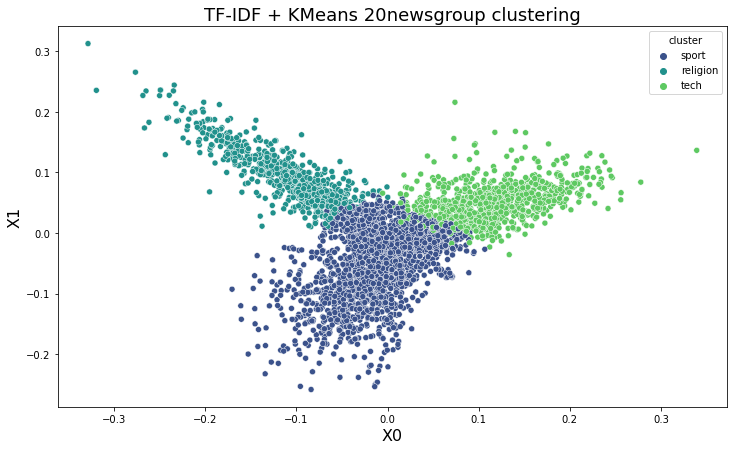

In [37]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

# Bag-Of-Words

In [39]:
from collections import Counter

In [46]:
 # Counter([y for x in df['cleaned'].values.flatten() for y in x.split()])

In [44]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 9.5 MB/s eta 0:00:00a 0:00:01


In [51]:
df.cleaned[0]

'tried best show believe surprised find sprint car race mini cars pigpens indeed short notice george'

In [59]:
text = df.cleaned.str.cat()

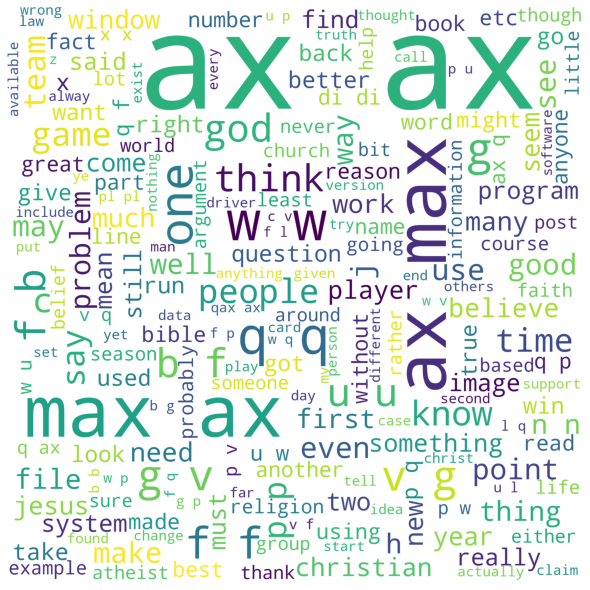

In [68]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

# wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(width = 2000, height = 2000,
                background_color ='white',
                min_font_size = 10).generate(text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
# plt.show()
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")